# Fine_tuning

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms

import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt


Bad key "text.kerning_factor" on line 4 in
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [6]:
train_dir = './cats_and_dogs_small/train'
validation_dir = './cats_and_dogs_small/validation'
test_dir = './cats_and_dogs_small/test'

train_path = glob.glob(train_dir+'/*/*.jpg')
validation_path = glob.glob(validation_dir+'/*/*.jpg')
test_path = glob.glob(test_dir+'/*/*.jpg')

In [7]:
mapping = {'dogs':0,'cats':1}
train_df = pd.DataFrame()
train_df['path'] = train_path
train_df['target'] = train_df['path'].str.split('/').str[-2]
train_df['target'] = train_df['target'].replace(mapping)

validation_df = pd.DataFrame()
validation_df['path'] = validation_path
validation_df['target'] = validation_df['path'].str.split('/').str[-2]
validation_df['target'] = validation_df['target'].replace(mapping)


test_df = pd.DataFrame()
test_df['path'] = test_path
test_df['target'] = test_df['path'].str.split('/').str[-2]
test_df['target'] = test_df['target'].replace(mapping)


In [9]:
class FileDataSet(Dataset):
    def __init__(self, df, trsf=None):
        self.filepaths = df['path'].values
        self.targets = df['target'].values
        self.trsf = trsf
    def __len__(self):
        return len(self.filepaths)
    def __getitem__(self, idx):
        # read image as RGB format (original is BGR)
        image = plt.imread(self.filepaths[idx])
        if len(image.shape)==2:
            image = np.expand_dims(image, 2)
            image = np.stack([image,image,image],axis=2)
        if self.trsf:
            image = self.trsf(image)
        target = self.targets[idx]
        filepath = self.filepaths[idx]
        return image, target

In [10]:
img_size = 224
trsf_data = {
        'train': transforms.Compose([transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.RandomRotation(20),
            transforms.RandomAffine(0, translate=(0.2, 0.2)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()]),
        'val': transforms.Compose([transforms.ToPILImage(),
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor()])}

trainDS = FileDataSet(train_df, trsf_data['train'])
validDS = FileDataSet(validation_df, trsf_data['val'])
testDS = FileDataSet(test_df, trsf_data['val'])

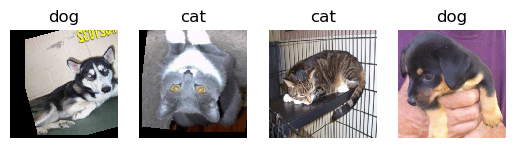

In [11]:
def plot_imges(k,num, mode):
    if mode=='train':
        temp_image, temp_target = trainDS[num]
    elif mode=='val':
        temp_image, temp_target = validDS[num]
    elif mode=='test':
        temp_image, temp_target = testDS[num]
    plt.subplot(1,4,k)
    plt.imshow(np.transpose(temp_image,(1,2,0)))
    plt.title('dog' if temp_target==0 else 'cat')
    plt.axis('off')

plot_imges(1,250,'train')
plot_imges(2,870,'train')
plot_imges(3,250,'val')
plot_imges(4,620,'val')

## pretrained model

In [12]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

Using cache found in /home/choiyj/.cache/torch/hub/pytorch_vision_v0.10.0
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
# freeze
for param in mobilenet.parameters():
    param.requires_grad = False

# replace the classifier
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(num_ftrs, 2,bias=True)

# parameters to update
params_to_update = []
for name,param in mobilenet.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 classifier.1.weight
	 classifier.1.bias


## Train

In [14]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
batch_size = 64
epochs = 10
lr = 0.001
optimizer = torch.optim.Adam(params_to_update, lr=lr)

trainloader = DataLoader(trainDS, batch_size=batch_size, shuffle=True, num_workers=4)
valloader = DataLoader(validDS, batch_size=batch_size, shuffle=False, num_workers=4)
testloader = DataLoader(testDS, batch_size=batch_size, shuffle=False, num_workers=4)

In [15]:
model = mobilenet.to(device)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(epochs):
    model.train()
    print(f'epoch : {epoch}')
    loss_tr = 0
    correct_tr = 0
    data_count_tr = 0
    for inputs,targets in trainloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        loss_tr += loss_item*len(targets)
        _, predicted = torch.max(outputs.data, 1)
        correct_tr += (predicted == targets).sum().item()
        data_count_tr += targets.size(0)
    print(f'train loss: {loss_tr/data_count_tr}, train acc: {correct_tr/data_count_tr}')

    loss_val = 0
    correct_val = 0
    data_count_val = 0
    with torch.no_grad():
        model.eval()
        for inputs, targets in valloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            loss_item = loss.item()
            loss_val += loss_item*len(targets)
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == targets).sum().item()
            data_count_val += targets.size(0)
    print(f'val loss: {loss_val/data_count_val}, val acc: {correct_val/data_count_val}')

        

epoch : 0
train loss: 0.5266570317745208, train acc: 0.7225
val loss: 0.2156378722190857, val acc: 0.9475
epoch : 1
train loss: 0.28481058120727537, train acc: 0.886875
val loss: 0.15414128735661506, val acc: 0.9525
epoch : 2
train loss: 0.251282639503479, train acc: 0.89
val loss: 0.1253754010796547, val acc: 0.96375
epoch : 3
train loss: 0.24089566707611085, train acc: 0.901875
val loss: 0.12716035082936286, val acc: 0.95125
epoch : 4
train loss: 0.2301156508922577, train acc: 0.90375
val loss: 0.10878217041492462, val acc: 0.95875
epoch : 5
train loss: 0.19860189974308015, train acc: 0.92
val loss: 0.11448632344603539, val acc: 0.95375
epoch : 6
train loss: 0.20510186731815339, train acc: 0.9225
val loss: 0.12053563840687274, val acc: 0.95375
epoch : 7
train loss: 0.23465305030345918, train acc: 0.8925
val loss: 0.09482239425182343, val acc: 0.97375
epoch : 8
train loss: 0.19609515786170958, train acc: 0.916875
val loss: 0.09478303253650665, val acc: 0.9675
epoch : 9
train loss: 0.2

In [16]:
model.eval()
correct_test = 0
data_count_test = 0
for inputs,targets in testloader:
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct_test += (predicted == targets).sum().item()
    data_count_test += targets.size(0)
print(f'test acc : {correct_test/data_count_test}')

test acc : 0.9575


# Skorch

In [17]:
mobilenet = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

# replace the classifier
num_ftrs = mobilenet.classifier[1].in_features
mobilenet.classifier[1] = nn.Linear(num_ftrs, 2,bias=True)

Using cache found in /home/choiyj/.cache/torch/hub/pytorch_vision_v0.10.0


In [18]:
layer_names = [name for name,_ in mobilenet.named_parameters()]
layer_names[-5:]

['features.18.0.weight',
 'features.18.1.weight',
 'features.18.1.bias',
 'classifier.1.weight',
 'classifier.1.bias']

In [19]:
from skorch.callbacks import Freezer
freezer = Freezer(lambda x: not x.startswith('classifier'))

In [20]:
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

net = NeuralNetClassifier(
    mobilenet,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.001,
    device=device,
    iterator_train__shuffle=True,
    optimizer=torch.optim.Adam,
    batch_size = 64,
    train_split=predefined_split(validDS),
    callbacks=[freezer]
)

In [21]:
net.fit(trainDS, y=None)
print('completed')

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4845       0.9463        0.2071  8.0016
      2        0.2856       0.9500        0.1570  7.5856
      3        0.2654       0.9563        0.1268  7.6493
      4        0.2400       0.9550        0.1348  8.5706
      5        0.2194       0.9613        0.1098  7.6862
      6        0.2200       0.9600        0.1091  7.6886
      7        0.2106       0.9500        0.1242  7.6643
      8        0.2056       0.9575        0.1106  7.6052
      9        0.2156       0.9575        0.1170  7.5886
     10        0.2079       0.9650        0.0953  7.6451
completed


In [22]:
from sklearn.metrics import accuracy_score as acc
y_pred = net.predict(testDS)
acc(testDS.targets, y_pred)

0.95625